### Obtained Perplexity: -8.41, Coherence: 0.31, Best Number of Topics= 60

In [3]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2013.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [7]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [8]:
df.head()

,year,Post
0,2013,"Depression and Money, Some Real TalkDepression..."
1,2013,What Being Alone and Scared in a Paris Airport...
2,2013,Being Ok with Not Being Ok: The Process I Use ...
3,2013,Being Judged in Diversity WorkBeing Judged in ...
4,2013,DENVER bound!! #RoadTrip2013DENVER bound!! #Ro...


In [9]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [10]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [11]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['depression', 'and', 'money', 'some', 'real', 'talkdepression', 'and', 'money', 'some', 'real', 'talk', 'this', 'is', 'the', 'first', 'in', 'series', 'of', 'conversations', 'about', 'depression', 'and', 'money', 'logan', 'sachon', 'so', 'we', 're', 'here', 'today', 'to', 'talk', 'about', 'depression', 'and', 'how', 'it', 'affects', 'our', 'money', 'martha', 'kaplan', 'not', 'well', 'it', 'has', 'what', 'would', 'characterize', 'as', 'negative', 'effect', 'ls', 'yes', 'think', 'you', 'are', 'right', 'about', 'that', 'we', 'both', 'have', 'some', 'personal', 'experience', 'with', 'this', 'say', 'mk', 'would', 'say', 'that', 'also', 'ls', 'so', 'we', 're', 'going', 'to', 'talk', 'about', 'this', 'martha', 'kaplan', 'is', 'not', 'your', 'real', 'name', 'though', 'maybe', 'it', 'should', 'be', 'mk', 'yes', 'have', 'requested', 'to', 'be', 'anonymous', 'because', 'of', 'my', 'job', 'it', 'hard', 'to', 'be', 'taken', 'seriously', 'in', 'your', 'place', 'of', 'business', 'if', 'it', 'widely'

In [12]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [13]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [14]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['depression', 'and', 'money', 'some', 'real', 'talkdepression', 'and', 'money', 'some', 'real', 'talk', 'this', 'is', 'the', 'first', 'in', 'series', 'of', 'conversations', 'about', 'depression', 'and', 'money', 'logan', 'sachon', 'so', 'we', 're', 'here', 'today', 'to', 'talk', 'about', 'depression', 'and', 'how', 'it', 'affects', 'our', 'money', 'martha', 'kaplan', 'not', 'well', 'it', 'has', 'what', 'would', 'characterize', 'as', 'negative', 'effect', 'ls', 'yes', 'think', 'you', 'are', 'right', 'about', 'that', 'we', 'both', 'have', 'some', 'personal', 'experience', 'with', 'this', 'say', 'mk', 'would', 'say', 'that', 'also', 'ls', 'so', 'we', 're', 'going', 'to', 'talk', 'about', 'this', 'martha', 'kaplan', 'is', 'not', 'your', 'real', 'name', 'though', 'maybe', 'it', 'should', 'be', 'mk', 'yes', 'have', 'requested', 'to', 'be', 'anonymous', 'because', 'of', 'my', 'job', 'it', 'hard', 'to', 'be', 'taken', 'seriously', 'in', 'your', 'place', 'of', 'business', 'if', 'it', 'widely',

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# data_words_nostops = remove_stopwords(data_words)
# data_words_bigrams = make_bigrams(data_words_nostops)

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# nlp = spacy.load("en_core_web_sm")

# # 1. Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized[:1])

# # 2. Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)

# # 3. Create Corpus
# texts = data_lemmatized

# # 4. Term Document Frequency and Create a bag of words
# bow_corpus = bow(dictionary=id2word, processed_docs=texts)

# # 5. Calculate low_tfidf_words
# # Keep only words with tfidf ranking <= x * len(dictionary)
# x = 0.2
# total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
# sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
# low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)

# # 6. Filter out least frequently used words
# no_below = 0.01
# keep_n = 10000
# dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
#                                                  no_below, keep_n)

# # 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
# dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)

# # 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# # created after least frequently and most commonly used words were filtered out.
# corpus = bow(dict_tfidf_filtered, texts)

# # View
# [[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"remember" + 0.010*"ok" + 0.009*"moment" + 0.009*"still" + '
  '0.008*"right" + 0.008*"feeling" + 0.008*"away" + 0.007*"last" + '
  '0.007*"serve" + 0.006*"accept"'),
 (1,
  '0.012*"experience" + 0.009*"feeling" + 0.009*"result" + 0.007*"natural" + '
  '0.007*"fear" + 0.007*"session" + 0.006*"test" + 0.006*"feedback" + '
  '0.005*"many" + 0.005*"assessment"'),
 (2,
  '0.020*"play" + 0.010*"project" + 0.008*"fun" + 0.007*"past" + '
  '0.006*"present" + 0.006*"friend" + 0.006*"face" + 0.006*"talk" + '
  '0.006*"stop" + 0.005*"kid"'),
 (3,
  '0.010*"paris" + 0.008*"happen" + 0.008*"friend" + 0.008*"travel" + '
  '0.008*"airport" + 0.007*"tony" + 0.006*"moment" + 0.006*"sophie" + '
  '0.006*"never" + 0.005*"stay"'),
 (4,
  '0.014*"stress" + 0.011*"plane" + 0.010*"worker" + 0.010*"flight" + '
  '0.008*"air" + 0.008*"rio" + 0.007*"pilbara" + 0.007*"union" + '
  '0.006*"accident" + 0.005*"crash"'),
 (5,
  '0.014*"worry" + 0.009*"also" + 0.008*"really" + 0.008*"mk" + 0.007*"dog" 

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.600549485462834


In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3454700333204892


In [34]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [35]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9998,"worry, also, really, mk, dog, talk, medication...","[depression, money, real, talkdepression, mone..."
1,1,3.0,0.9994,"paris, happen, friend, travel, airport, tony, ...","[alone, scared, paris, airport, teach, alone, ..."
2,2,0.0,0.9993,"remember, ok, moment, still, right, feeling, a...","[ok, process, accept, statebee, ok, ok, proces..."
3,3,1.0,0.9996,"experience, feeling, result, natural, fear, se...","[judge, diversity, workbee, judge, diversity, ..."
4,4,5.0,0.8148,"worry, also, really, mk, dog, talk, medication...","[denver, bind, roadtrip, denver, bind, roadtri..."


In [36]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9998,"worry, also, really, mk, dog, talk, medication...","[depression, money, real, talkdepression, mone..."
1,1,3.0,0.9994,"paris, happen, friend, travel, airport, tony, ...","[alone, scared, paris, airport, teach, alone, ..."
2,2,0.0,0.9993,"remember, ok, moment, still, right, feeling, a...","[ok, process, accept, statebee, ok, ok, proces..."
3,3,1.0,0.9996,"experience, feeling, result, natural, fear, se...","[judge, diversity, workbee, judge, diversity, ..."
4,4,5.0,0.8148,"worry, also, really, mk, dog, talk, medication...","[denver, bind, roadtrip, denver, bind, roadtri..."
5,5,6.0,0.9993,"basal_ganglia, photo, game, new, baseball, add...","[change, rapid, recovery, gradualchange, rapid..."
6,6,6.0,0.9972,"basal_ganglia, photo, game, new, baseball, add...","[april, leggyapril, leggy, college, turn, imag..."
7,7,2.0,0.9996,"play, project, fun, past, present, friend, fac...","[cure, anxietyhow, cure, anxiety, first, panic..."
8,8,2.0,0.9994,"play, project, fun, past, present, friend, fac...","[reflect, projecting, projection, happen, comm..."
9,9,1.0,0.9654,"experience, feeling, result, natural, fear, se...","[entire, human, life, cycle, dictate, quora, r..."


In [55]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

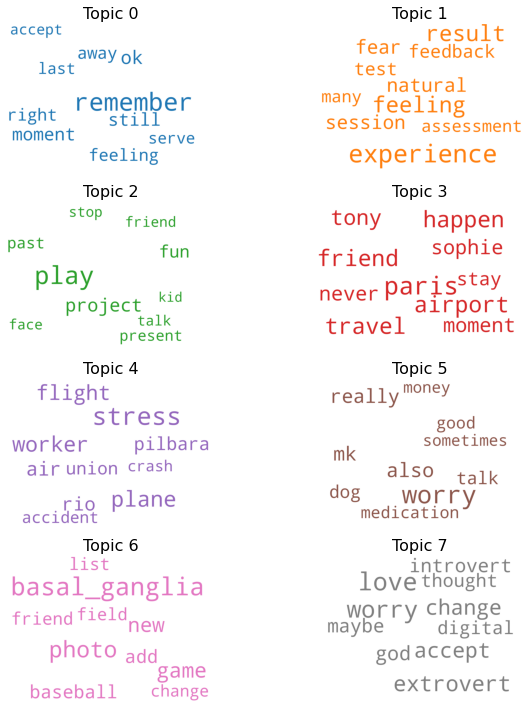

In [37]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [57]:
df_dominant_topic.to_csv("Medium2013.csv")

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=6)


26


(8, 0.0702457038615133, 0.28957036620578425)

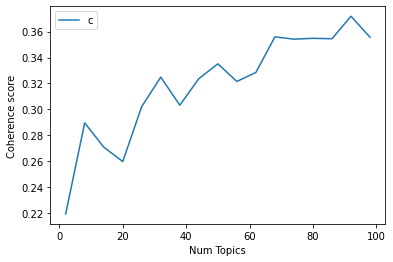

In [21]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
print(x[4])
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)